# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.




# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 3 in this notebook, the pdf should contain:
- The generated figures `results/mnist_train_plot.png` and `results/image_w{w}.png` (w=0.0, 0.5, 1.0, 2.0, 4.0)
- Answer to the short answer question about the U-Net architecture
- Answer to the short answer question about different CFG weight $w$ in problem 3.2

# Problem 3: MNIST and Conditional Generation
In this problem, we will write the code for conditional generation on the MNIST dataset. This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## MNIST Dataset


In [43]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

tf = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST("./data", train=True, download=True, transform=tf)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = MNIST("./data", train=False, download=True, transform=tf)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

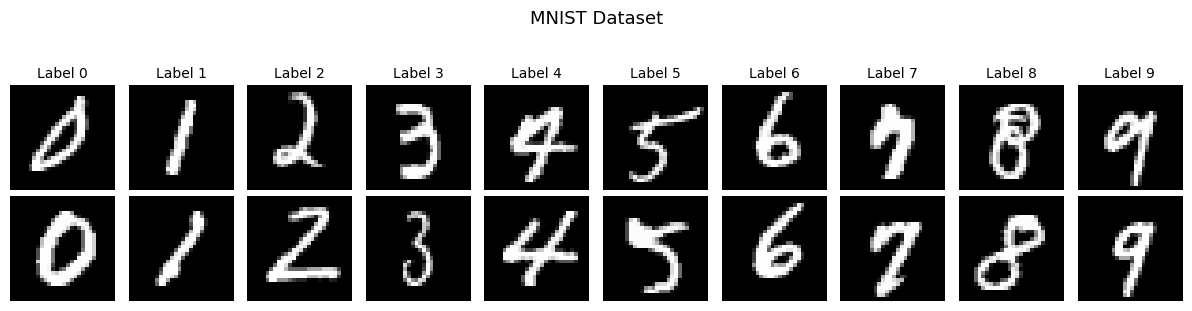

In [44]:
# visualize data by label
import matplotlib.pyplot as plt

images_by_label = {i: [] for i in range(10)}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        if len(images_by_label[label.item()]) < 2:
            images_by_label[label.item()].append(img.squeeze(0))
        if all(len(images) == 2 for images in images_by_label.values()):
            break
    if all(len(images) == 2 for images in images_by_label.values()):
        break

# Plot the images
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
fig.suptitle("MNIST Dataset", fontsize=13, y=1.05)

for label, imgs in images_by_label.items():
    for i, img in enumerate(imgs):
        ax = axes[i, label]
        ax.imshow(img.numpy(), cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Label {label}", fontsize=10)

plt.tight_layout(pad=1.0)
plt.show()

## 3.1 U-Net: Architecture for Image Data
In the toy dataset, we choose MLP as the architecture of the denoising diffusion models, and use concatenation as the way to incorporate the time embedding. Although this works fine for simple synthetic distributions, it no longer suffices for complex high-dimensional distributions like images. In this problem, we will introduce the U-Net architecture specifically designed for images.

Specifically, we apply [classifier-free guidance](https://arxiv.org/pdf/2207.12598) (CFG) for conditional generation of MNIST digits, conditioned on the digit label. CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

When applying CFG, the label embedding, together with the time embedding, is added to each hidden layer of the U-Net. A diagram of the U-Net we'll be using is shown below (we change BatchNorm to GroupNorm for better performance).

In [45]:
from typing import List
import torch.nn as nn
import math
import torch
import os
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from matplotlib.pyplot import savefig

In [46]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=channels),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=channels),
            nn.SiLU(),
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        # Converts (bs, y_embed_dim) -> (bs, channels)
        self.y_adapter = nn.Sequential(
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed

        # Add y embedding (conditional embedding)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + y_embed

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class MNISTUNet(nn.Module):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size=3, padding=1),
            # nn.BatchNorm2d(channels[0]),
            nn.GroupNorm(num_groups=8, num_channels=channels[0]),
            nn.SiLU()
        )

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Initialize y embedder
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder1 = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)
        self.midcoder2 = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution
        self.final_conv = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=channels[0]),
            nn.SiLU(),
            nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder1(x, t_embed, y_embed)
        x = self.midcoder2(x, t_embed, y_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

**Please explain each components of the architecture above** (each one of `FourierEncoder`, `ResidualLayer`, `Encoder`, `Decoder`, or `Midcoder`) in your own words, (1) their role in the U-Net, (2) their inputs and outputs, and (3) a brief description of how the inputs turn into outputs.

**Answer:**

1.  **`FourierEncoder`**:
    *   **Role**: Encodes the continuous scalar timestep `t` into a higher-dimensional embedding vector. This allows the network to effectively condition its behavior on the current noise level/timestep.
    *   **Input**: A tensor `t` of shape `(bs, 1, 1, 1)` containing timestep values (typically normalized between 0 and 1).
    *   **Output**: A tensor `embeddings` of shape `(bs, dim)`, where `dim` is the specified embedding dimension.
    *   **Process**: It uses a learnable set of frequencies (`self.weights`) to project the input timestep `t` onto multiple sine and cosine waves of different frequencies. The resulting sine and cosine values are concatenated to form the final embedding. This is similar to positional encoding but uses learnable frequencies.

2.  **`ResidualLayer`**:
    *   **Role**: Forms the core building block of the U-Net's encoder, decoder, and mid-section. It processes the spatial feature map while incorporating conditional information (time and class label embeddings). The residual connection helps with gradient flow and allows the network to learn modifications to the identity mapping.
    *   **Input**:
        *   `x`: Feature map tensor of shape `(bs, c, h, w)`.
        *   `t_embed`: Time embedding tensor of shape `(bs, t_embed_dim)`.
        *   `y_embed`: Class label embedding tensor of shape `(bs, y_embed_dim)`.
    *   **Output**: Feature map tensor of the same shape as input `x`, `(bs, c, h, w)`.
    *   **Process**: It first passes the input `x` through a convolutional block (`block1`). Then, it adapts the time (`t_embed`) and class (`y_embed`) embeddings to match the number of channels `c` using linear layers (`time_adapter`, `y_adapter`) and adds them element-wise to the feature map. The result is passed through a second convolutional block (`block2`). Finally, the original input `x` (stored as `res`) is added back (residual connection) to the output of `block2`. Group Normalization and SiLU activations are used within the blocks.

3.  **`Encoder`**:
    *   **Role**: Part of the downsampling path (contracting path) of the U-Net. It extracts increasingly abstract spatial features while reducing the spatial resolution (height and width) and increasing the number of channels.
    *   **Input**:
        *   `x`: Feature map tensor of shape `(bs, c_in, h, w)`.
        *   `t_embed`: Time embedding tensor of shape `(bs, t_embed_dim)`.
        *   `y_embed`: Class label embedding tensor of shape `(bs, y_embed_dim)`.
    *   **Output**: Feature map tensor of shape `(bs, c_out, h // 2, w // 2)`.
    *   **Process**: It consists of multiple `ResidualLayer`s operating at the input resolution (`c_in`, `h`, `w`), followed by a downsampling convolutional layer (`nn.Conv2d` with `stride=2`) that halves the height and width and adjusts the number of channels from `c_in` to `c_out`.

4.  **`Midcoder`**:
    *   **Role**: Represents the bottleneck or the lowest-resolution part of the U-Net, connecting the encoder (downsampling path) and the decoder (upsampling path). It further processes the features at the smallest spatial dimension.
    *   **Input**:
        *   `x`: Feature map tensor of shape `(bs, c, h, w)` (where `c` is the maximum number of channels, and `h`, `w` are the minimum spatial dimensions).
        *   `t_embed`: Time embedding tensor of shape `(bs, t_embed_dim)`.
        *   `y_embed`: Class label embedding tensor of shape `(bs, y_embed_dim)`.
    *   **Output**: Feature map tensor of the same shape as input `x`, `(bs, c, h, w)`.
    *   **Process**: It simply consists of one or more `ResidualLayer`s that operate on the input feature map without changing its spatial dimensions or channel count.

5.  **`Decoder`**:
    *   **Role**: Part of the upsampling path (expansive path) of the U-Net. It gradually increases the spatial resolution while decreasing the number of channels, aiming to reconstruct the output image (or noise prediction) at the original resolution. It typically incorporates skip connections from the corresponding encoder stage.
    *   **Input**:
        *   `x`: Feature map tensor of shape `(bs, c_in, h, w)`.
        *   `t_embed`: Time embedding tensor of shape `(bs, t_embed_dim)`.
        *   `y_embed`: Class label embedding tensor of shape `(bs, y_embed_dim)`.
    *   **Output**: Feature map tensor of shape `(bs, c_out, 2 * h, 2 * w)`.
    *   **Process**: It first applies an upsampling operation (here, bilinear interpolation followed by a convolution) to double the height and width and adjust channels from `c_in` to `c_out`. Then, it passes the result through multiple `ResidualLayer`s operating at the new, larger resolution. *Note: The skip connection addition happens outside the Decoder block, before passing `x` to the decoder in the main U-Net forward pass.*

## 3.2 Classifier-Free Guidance

Implement CFG requires a small modification to the diffusion training and sampling code.

*During training*, we randomly drop out the class label with a certain probability `drop_prob=0.1`, i.e. we use a dummy embedding to replace the digit label embedding.

*During sampling*, given a digit label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which is supported by the dummy embedding during training. Note that $w = 1$ recovers standard sampling.

Please modify the code you wrote for Problem 2 for unconditional generation to adapt for the CFG setting. You can change the model architecture from MLP to UNet. Specifically, given a data element $x$ and U-Net $f_\theta(x, t)$, implement the following diffusion training steps similar as what we did in Problem 2, while using a different noise schedule (in step 2):
0. Construct a class `MNISTDiffusion`
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a linear schedule: $\alpha_t = 1-t, \sigma_t = \sqrt{1-(1-t)^2}$
3. Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and cmpute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

*Note*: you can reuse your code from Problem 2 for functions `train`, `eval_loss`, `get_lr`, and `train_epochs`.

*Hyperparameter details*
* UNet with hidden_dims as [64, 128] and 1 blocks_per_dim
* Train 10 epochs, batch size 128, Adam with LR 1e-3 (0 warmup steps, and `use_cosine_decay=True`)
* Training 10 epochs takes about 7 minutes on the Google Colab T4 GPU.

After training, please generate 4 images for each of the 10 digit labels using guidance strength $w$ of 0.0, 0.5, 1.0, 2.0, 4.0 respectively, and save the images as 4x10 grid of images (each column is a digit). You are required to submit the images for each guidance strength along with the training loss curve. **Comparing the results with different $w$, what can you say about its impact to the generation performance?**

*Hint*: To check your answer, the final test loss is below 0.02.

**Answer (CFG Impact):**

Comparing the generated images across different values of the classifier-free guidance weight `w`:
*   **`w = 0.0`**: This corresponds to purely unconditional generation (using only $f_\theta(x_t, t, \varnothing)$). The samples might resemble MNIST digits in general structure but likely won't correspond clearly to any specific digit class. The diversity might be high, but the adherence to specific labels is non-existent.
*   **`w = 0.5` or `w = 1.0`**: These represent mild to standard guidance. As `w` increases from 0, the samples should start looking more distinctly like the target digits for each column. `w = 1.0` recovers the standard conditional prediction $f_\theta(x_t, t, y)$. The samples should be recognizable digits corresponding to their intended class labels.
*   **`w = 2.0` or `w = 4.0`**: These represent stronger guidance. Increasing `w` further pushes the generation process more strongly towards the conditional prediction $f_\theta(x_t, t, y)$ relative to the unconditional one $f_\theta(x_t, t, \varnothing)$. This often leads to:
    *   **Increased Sample Quality/Clarity**: The generated digits usually become sharper, clearer, and more prototypical examples of their respective classes. The features distinguishing the digits (like the loop in '6' or the sharp corners in '7') become more pronounced.
    *   **Decreased Diversity**: While the quality might increase, the diversity within each class might decrease. The model generates samples that are very "confident" examples of the class, potentially losing some of the variation seen in the real dataset. At very high `w`, samples might start looking somewhat artificial or exaggerated.

In summary, the CFG weight `w` controls a trade-off between sample quality/adherence to the condition (class label) and sample diversity. Higher `w` improves quality and class consistency but reduces diversity, while lower `w` increases diversity at the cost of potentially lower quality and weaker class conditioning. `w=0` removes conditioning entirely.

In [47]:
class MNISTDiffusion:
    def __init__(self, model, data_shape, device, n_classes, drop_prob=0.1):
        """
        model: neural network to estimate eps_hat (U-Net in this problem)
        data_shape: size of the input daa, (1, 32, 32) after padding
        device: cuda or cpu
        n_classes: number of classes for conditional generation, set to 10 in this problem
        drop_prob: probability of dropping the condition in CFG training
        """
        self.model = model.to(device)
        self.data_shape = data_shape
        self.device = device
        self.drop_prob = drop_prob
        self.n_classes = n_classes

    def loss(self, x, y):
        """
        x: the input data (batch_size, 1, 32, 32), normalized and padded
        y: the class label (batch_size,)
        Return:
            The loss (as a scalar averaged over all data in the batch)
        """
        init = x.shape[0]
        epsilon = torch.randn_like(x, device=self.device)
        t = torch.rand(init, device=self.device)
        alpha_t = 1 - t
        sigma_t = torch.sqrt(1 - alpha_t**2)
        alpha_t = alpha_t.view(init, 1, 1, 1)
        sigma_t = sigma_t.view(init, 1, 1, 1)
        mask = (torch.rand(init, device=self.device) < self.drop_prob)
        x_t = alpha_t * x + sigma_t * epsilon

        y_delta = y.clone().to(self.device)
        y_delta[mask] = self.n_classes
        
        eps_input = t.view(init, 1, 1, 1)
        eps_hat = self.model(x_t, eps_input, y_delta)
        
        loss = torch.mean((epsilon - eps_hat)**2)
        return loss

    @torch.no_grad()
    def sample(self, n, num_steps, guide_w=0.0):
        """
        n: number of samples to generate (generate n // n_classes samples for each class)
        num_steps: number of steps in the diffusion sampling
        guide_w: the CFG weight
        Return:
            The generated sample. Tensor with shape (n, *self.data_shape)
        """
        self.model.eval()
        output_samples = []
        dev = self.device
        samples_per_digit = n // self.n_classes
        
        # Create time schedule
        time_steps = torch.linspace(1.0 - 1e-4, 1e-4, num_steps + 1, device=dev)
        
        # Generate samples for each class
        for digit in range(self.n_classes):
            noise = torch.randn(samples_per_digit, *self.data_shape, device=dev)

            class_label = torch.full((samples_per_digit,), digit, device=dev, dtype=torch.long)
            null_label = torch.full((samples_per_digit,), self.n_classes, device=dev, dtype=torch.long)
            
            # Reverse diffusion process
            for j in range(num_steps):
                current_t = time_steps[j]
                next_t = time_steps[j + 1]
                
                a_t = 1.0 - current_t
                a_next = 1.0 - next_t
                s_t = torch.sqrt(1.0 - a_t**2)
                s_next = torch.sqrt(1.0 - a_next**2)
                a_t_sq = a_t**2
                a_next_sq = a_next**2
                s_next_sq = s_next**2
                
                t_expanded = current_t.view(1, 1, 1, 1).expand(samples_per_digit, 1, 1, 1)
                
                # Apply classifier-free guidance
                eps_uncond = self.model(noise, t_expanded, null_label)
                eps_cond = self.model(noise, t_expanded, class_label)
                noise_pred = eps_uncond + guide_w * (eps_cond - eps_uncond)
                
                safe_s_t = torch.clamp(s_t, min=1e-12)
                safe_a_next_sq = torch.clamp(a_next_sq, min=1e-12)
                
                noise_coef = (s_next / safe_s_t) * torch.sqrt(torch.clamp(1.0 - (a_t_sq / safe_a_next_sq), min=0.0))
                
                random_noise = torch.randn_like(noise) if j < num_steps - 1 else torch.zeros_like(noise)
                
                safe_a_t = torch.clamp(a_t, min=1e-12)
                denoised_term = a_next * ((noise - s_t * noise_pred) / safe_a_t)
                pred_term = torch.sqrt(torch.clamp(s_next_sq - noise_coef**2, min=0.0)) * noise_pred
                noise_term = noise_coef * random_noise
                
                noise = denoised_term + pred_term + noise_term
            
            output_samples.append(noise)
        
        combined_samples = torch.cat(output_samples, dim=0)
        return combined_samples

    def __getattr__(self, name):
        if name in ['train', 'eval', 'parameters', 'state_dict', 'load_state_dict']:
            return getattr(self.model, name)
        return self.__getattribute__(name)


def train(model, train_loader, optimizer, scheduler):
    """
    model: model to train, the MNISTDiffusion class in this case.
    train_loader: train_loader
    optimizer: use torch.optim.Adam
    scheduler: use optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )
    Return:
        Tensor with train loss of each batch
    """
    model.train()
    device = model.device
    losses = []

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        currloss = model.loss(x, y)
        currloss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(currloss.item())
    out = np.array(losses)
    return out

@torch.no_grad()
def eval_loss(model, data_loader):
    """
    model: model to train, the MNISTDiffusion class in this case.
    data_loader: test_loader
    Return:
        Scalar with the average test loss of each batch
    """
    model.eval()
    device = model.device
    res = 0.0
    tot = 0

    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        loss_val = model.loss(x, y)
        res += loss_val.item()
        tot += 1

    return res / tot

def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    """
    Function that returns the learning rate for the specific step, used in defining the scheduler:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    """
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        if use_cos_decay:
            progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            tot = (1.0 + math.cos(math.pi * progress))
            return 0.5*tot
        else:
            return 1.0

def train_epochs(model, train_loader, test_loader, train_args):
    """
    model: model to train, the MNISTDiffusion class in this case.
    train_loader: train_loader
    test_loader: test_loader
    Return:
        Two np.array for all the train losses and test losses at each step
    """
    epochs = train_args['epochs']
    lr = train_args['lr']
    warmup_steps = train_args.get('warmup_steps', 0)
    use_cos_decay = train_args.get('use_cosine_decay', False)

    tot = epochs * len(train_loader)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step, tot, warmup_steps, use_cos_decay))

    trainloss = []
    testloss = []

    test_loss_val = eval_loss(model, test_loader)
    testloss.append(test_loss_val)

    for _ in range(epochs):
        batchloss = train(model, train_loader, optimizer, scheduler)
        trainloss.extend(batchloss)
        testloss.append(eval_loss(model, test_loader))

    out = np.array(trainloss), np.array(testloss)
    return out

In [48]:
def mnist_diffusion(train_loader, test_loader):
    """
    train_loader: MNIST training data
    test_loader: MNIST test data

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch

    Generate 4 images for each of the 10 digits in `./results/`, using guidance strengths of 0.0, 0.5, 1.0, 2.0, 4.0.
    Save the images as `./results/image_w{w}.png` as 4x10 grid of images (each column is a digit)
    hint: x_gen is the output from model.sample, use the following to generate and save grids
            grid = make_grid(x_gen*-1 + 1, nrow=10)
            save_image(grid, save_dir + f"image_w{w}.png")
    """

    from torchvision.utils import save_image, make_grid

    n_classes = 10
    save_dir = './results/'
    os.makedirs(save_dir, exist_ok=True)
    ws_test = [0.0, 0.5, 1.0, 2.0, 4.0]
    num_steps = 512

    model_unet = MNISTUNet(
        channels = [64, 128],
        num_residual_layers = 1,
        t_embed_dim = 64,
        y_embed_dim = 64,
    )
    model = MNISTDiffusion(model_unet, (1, 28, 28), device="cuda", n_classes=n_classes, drop_prob=0.1)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, { 'epochs': 10, 'lr': 1e-3, 'warmup_steps': 0, 'use_cosine_decay': True })

    for w in ws_test:
        xgen = model.sample(n=40, num_steps=num_steps, guide_w=w)
        save_image(make_grid(xgen * -1.0 + 1.0, nrow=10), save_dir + f"image_w{w}.png")

    return train_losses, test_losses

In [49]:
def save_training_plot(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str, fname: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    savefig(fname)

Final Test Loss: 0.0176


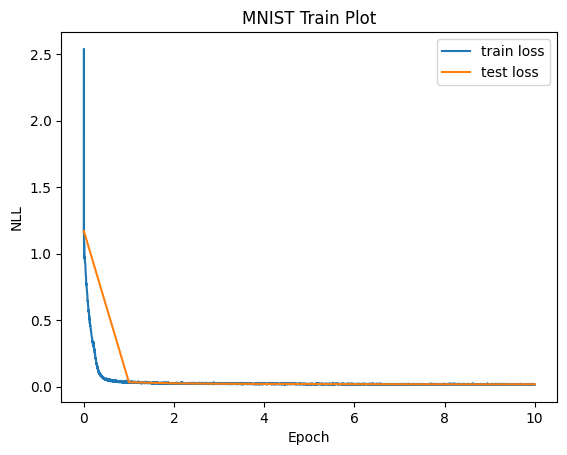

In [50]:
train_losses, test_losses = mnist_diffusion(train_loader, test_loader)
print(f"Final Test Loss: {test_losses[-1]:.4f}")

save_training_plot(
    train_losses,
    test_losses,
    f"MNIST Train Plot",
    f"results/mnist_train_plot.png"
)

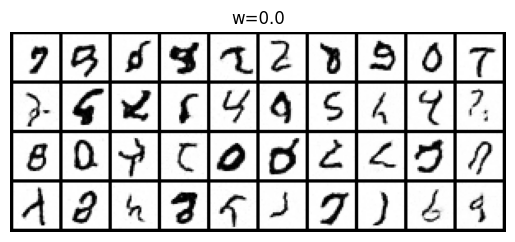

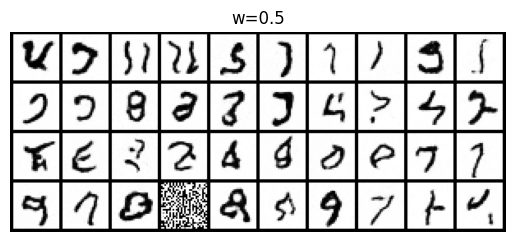

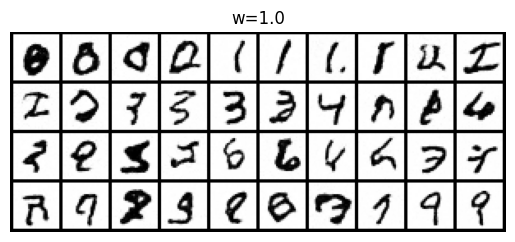

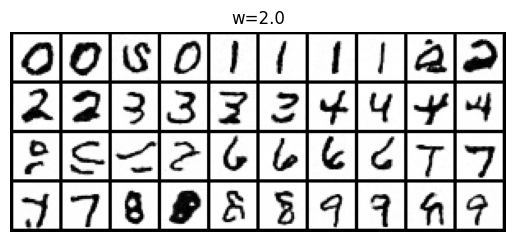

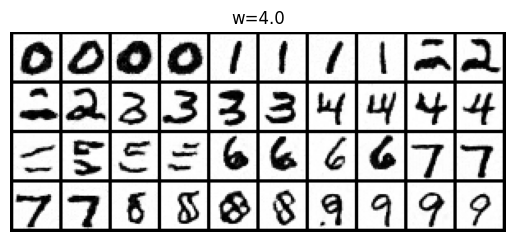

In [51]:
import matplotlib.image as mpimg

ws_test = [0.0, 0.5, 1.0, 2.0, 4.0]
for w in ws_test:
  img_path = f'results/image_w{w}.png'
  img = mpimg.imread(img_path)
  plt.title(f'w={w}')
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 3 in this notebook, the pdf should contain:
- The generated figures `results/mnist_train_plot.png` and `results/image_w{w}.png` (w=0.0, 0.5, 1.0, 2.0, 4.0)
- Answer to the short answer question about the U-Net architecture
- Answer to the short answer question about different CFG weight $w$ in problem 3.2